# FlowGrid Example

FlowGrid is a density-based clustering algorithm with grid-based approximation that can perform fast and accurate clustering on very large scRNA-seq data sets. This notebook is a simple example of how you can use FlowGrid to do clustering.

## Import FlowGrid and Scanpy

In [1]:
import FlowGrid as fg
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

## Load and prepocess the data in Scanpy

Data set is from Hrvatin et.al(2017), you can download the data set from https://storage.googleapis.com/h5ad/2017-12-Hrvatin-et-al-NNeuroscience/GSE102827_merged_all_raw.h5ad. Basic preprocessing steps such as Normalization, Highly variable genes selection are necessary for better clustering results.

In [2]:
adata = sc.read("~/Dataset/2017-12-Hrvatin-et-al-NNeuroscience/GSE102827_merged_all_raw.h5ad")

In [3]:
#Normalization
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [4]:
#Highly variable genes selection
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


We can take a look at the AnnData

In [5]:
adata

View of AnnData object with n_obs × n_vars = 65539 × 3242
    obs: 'stim', 'sample', 'maintype', 'celltype', 'subtype'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## autoFlowGrid

Users can use autoFlowGrid to effectively search the parameter space and the recommended parameter with the outputted CHI report. To use autoFlowGrid, low-dimensional data is required, by default, reducing the dimensionality of the data to 5 dimensions is recommended.

In [6]:
sc.tl.pca(adata, n_comps=5)

recomm_parameters,CHI_report = fg.autoFlowGrid(adata)

computing PCA
    on highly variable genes
    with n_comps=5
    finished (0:00:06)


autoFlowGrid completed in : 15.678 seconds.
53 sets of parameters are stored.
5 sets of parameters are recommended.



<b>Note</b>: All of the executions of FlowGrid will be stored in AnnData, you can clean the data later using the <i>clean_labels<i> function.

## autoFlowGrid results

In [8]:
recomm_parameters

['MinDenB_50_binN_13_eps_1_MinDenC_100_FlowGrid',
 'MinDenB_50_binN_18_eps_2_MinDenC_100_FlowGrid',
 'MinDenB_50_binN_18_eps_3_MinDenC_100_FlowGrid',
 'MinDenB_50_binN_17_eps_2_MinDenC_100_FlowGrid',
 'MinDenB_50_binN_17_eps_3_MinDenC_100_FlowGrid']

In [9]:
CHI_report.loc[recomm_parameters] 

,uCHI,CHI,Nobs,OurliersPortion
MinDenB_50_binN_13_eps_1_MinDenC_100_FlowGrid,5081498.0,181482.0,28.0,0.149987
MinDenB_50_binN_18_eps_2_MinDenC_100_FlowGrid,4346775.0,334367.0,13.0,0.146783
MinDenB_50_binN_18_eps_3_MinDenC_100_FlowGrid,4346775.0,334367.0,13.0,0.146783
MinDenB_50_binN_17_eps_2_MinDenC_100_FlowGrid,4206972.0,300498.0,14.0,0.134515
MinDenB_50_binN_17_eps_3_MinDenC_100_FlowGrid,4206972.0,300498.0,14.0,0.134515


If you have a reference label, you can use the <i>AdjustedRandScore()</i> function to get an ARI for FLowGrid labels compared with reference labels.

In [10]:
fg.AdjustedRandScore(adata,recomm_parameters,['maintype','celltype'],removenoise = True)

,maintype,celltype
MinDenB_50_binN_13_eps_1_MinDenC_100_FlowGrid,0.82,0.55
MinDenB_50_binN_18_eps_2_MinDenC_100_FlowGrid,0.89,0.59
MinDenB_50_binN_18_eps_3_MinDenC_100_FlowGrid,0.89,0.59
MinDenB_50_binN_17_eps_2_MinDenC_100_FlowGrid,0.89,0.59
MinDenB_50_binN_17_eps_3_MinDenC_100_FlowGrid,0.89,0.59


You can choose what parameters you want to save based on CHI_report, and remove all the other parameters by <i>clean_labels()</i> function.

In [11]:
fg.clean_labels(adata,recomm_parameters)

autoFlowGrid results are stores as FlowGrid1, 2, 3, 4, 5

In [12]:
adata

AnnData object with n_obs × n_vars = 65539 × 3242
    obs: 'stim', 'sample', 'maintype', 'celltype', 'subtype', 'FlowGrid1', 'FlowGrid2', 'FlowGrid3', 'FlowGrid4', 'FlowGrid5'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Comparison with Scanpy leiden

In [13]:
#Scanpy leiden clustering for comparison
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)

#umap
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:31)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:46)


## Visualization

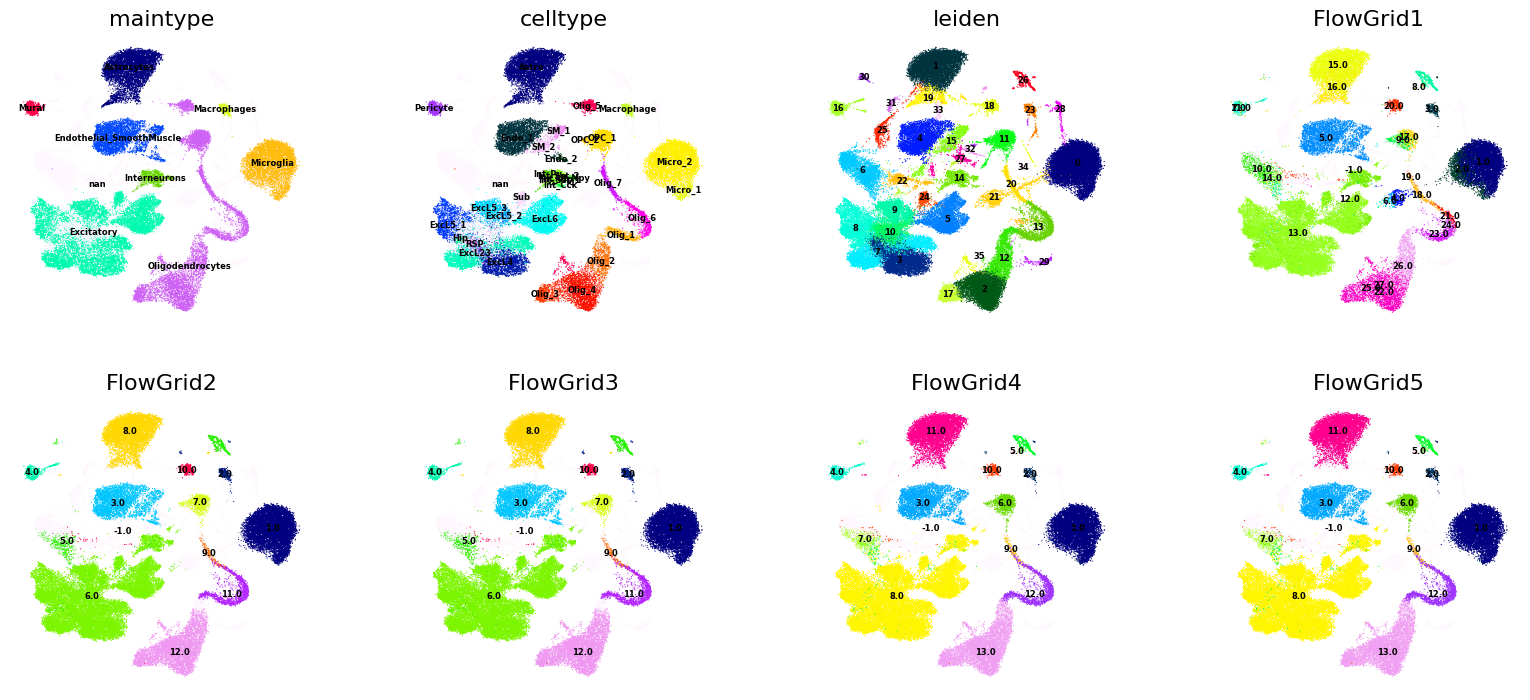

In [14]:
sc.settings.set_figure_params(dpi=100,fontsize = 16)
sc.pl.umap(adata, color=['maintype','celltype','leiden','FlowGrid1', 'FlowGrid2', 'FlowGrid3', 'FlowGrid4', 'FlowGrid5'], frameon =False, palette = 'gist_ncar',legend_loc = 'on data', legend_fontsize = 6, size = 3)

## (Optional) consensusFlowGrid

To utlize FlowGrid with high-dimensional data, you can use the <i>consensusFlowGrid()</i> function.

In [15]:
sc.tl.pca(adata, n_comps=30)
fg.consensusFlowGrid(adata, nDims=30)

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:14)


Cluster Ensembles
    - number of classes: 14
    - solver: mcla
    - length of base clustering labels: 65539
    - number of base clusters: 10
ConsensusFlowGrid completed in : 43.676 seconds.



In [16]:
fg.AdjustedRandScore(adata,['consensusFlowGrid','autoFlowGrid'],['maintype','celltype'],removenoise = True)

,maintype,celltype
consensusFlowGrid,0.81,0.53
autoFlowGrid,0.89,0.59


In [17]:
adata

AnnData object with n_obs × n_vars = 65539 × 3242
    obs: 'stim', 'sample', 'maintype', 'celltype', 'subtype', 'FlowGrid1', 'FlowGrid2', 'FlowGrid3', 'FlowGrid4', 'FlowGrid5', 'leiden', 'autoFlowGrid', 'consensusFlowGrid'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'maintype_colors', 'celltype_colors', 'leiden_colors', 'FlowGrid1_colors', 'FlowGrid2_colors', 'FlowGrid3_colors', 'FlowGrid4_colors', 'FlowGrid5_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

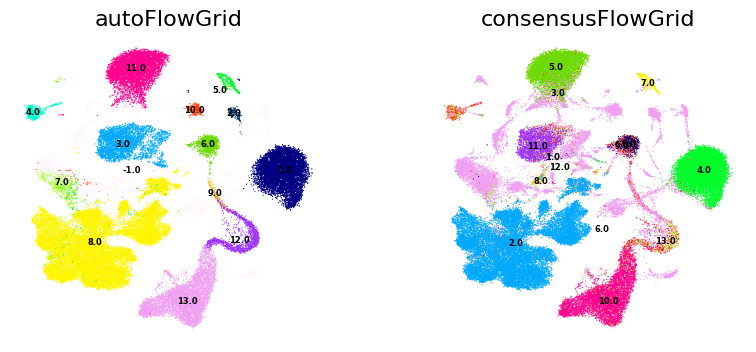

In [25]:
sc.settings.set_figure_params(dpi=100,fontsize = 16)
sc.pl.umap(adata, color=['autoFlowGrid','consensusFlowGrid'], frameon =False, palette = 'gist_ncar',legend_loc = 'on data', legend_fontsize = 6, size = 3)